## Business Goal 

Enhance the reach and impact of content shared on "MakeupAddiction" by predicting the popularity of posts, thus enabling creators and brands to engage more effectively with their audience.In this section, our primary focus will be on predicting the score of a submission. By analyzing the contributing factors to the model, we aim to impart insights into what is crucial when posting high-score in the MakeupAddiction subreddit.

## Technical Goal

We will extract and engineer several features from our dataset: Post Length, Makeup Theme, Posting Hour, Categorical Features, Creator Popularity, and Text Length. A Gradient Boosted Regressor and Random Forest Regressor will be employed as the supervised regression model, trained on these features with the objective of predicting the `score` of a post, which serves as our popularity metric. We will partition the data into training and validation sets to evaluate the model’s generalizability. Performance will be assessed using the root-mean-square error (RMSE) metric and R Square metric. Lower RMSE scores will be indicative of more accurate predictions of post popularity. Higher R square means larger proportion of the variability in the target variable is accounted for by the model.This strategy aims to optimize engagement by aligning content creation with data-driven predictions.

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

%pip install plotly
%pip install tabulate

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
  Using cached pyspark-3.4.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.2
    Uninstalling py4j-0.10.9.2:
      Successfully uninstalled py4j-0.10.9.2
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.2.0
    Uninstalling pyspark-3.2.0:
      Successfully uninstalled pyspark-3.2.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel 

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
import pandas as pd

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

import plotly.express as px
from tabulate import tabulate
from pyspark.ml import PipelineModel

In [4]:
spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9bc74b82-e904-4793-ae1f-76c3cfbed54f;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 382ms :: artifacts dl 23ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

In [5]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-861795727138/project/submissions/yyyy=*


23/12/07 08:43:43 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/12/07 08:43:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the submissions dataframe is 95,932x68
CPU times: user 2.27 s, sys: 220 ms, total: 2.49 s
Wall time: 5min 31s


In [7]:
topcreators= pd.read_csv('../../data/csv/top100creator.csv')
topcreators= topcreators['author'].to_list()

In [9]:
submissions_var= submissions.withColumn("created_hour",F.hour(F.to_timestamp(F.col("created_utc").cast('int'))))\
                                            .withColumn('text_length',F.length(F.col('selftext')))\
                                            .withColumn("title_length", F.length(F.col("title")))\
                                            .withColumn("is_top_100_creator", F.col("author").isin(topcreators))\
                                            .withColumn("is_peak_hour", F.col("created_hour").isin([16, 17, 18, 19, 20, 21, 22, 23, 0]))\
                                            .withColumn("has_media", F.col("media").isNotNull() | F.col("media_embed").getField('content').isNotNull())\
                                            .withColumn("is_long_text",(F.col('text_length') > 200))

# Dummy varaibles(code improved with assistance from OpenAI's ChatGPT )
from functools import reduce

categories_dict = {
    "skincare": ["skin","skincare","body", "hair", "facial", "nails", "lip", "sunscreen", "SPF", "acne", "pimples", "scar", "aging"],
    "skincare_product": ["moisturizer", "cleanser", "serum", "toner", "lotion","gel","mask","mist", "oil"],
    "skincare_product_brand": ["Clinique", "Neutrogena", "Cetaphil", "Kiehl's", "Olay","La Mer","Origins","Fresh","Shiseido","Avene"],
    "makeup": ["makeup","beauty","Sephora","bodypaint", "cosmetics", "style", "artist", "cosplay", "fashion", "celebrity", "party", "wedding", "palette"],
    "makeup_product": ["eyeliner", "contour", "foundation", "blush", "lipstick", "concealer","palette", "highlighter","powder","spray","blush"],
    "makeup_product_brand": ["MAC", "NARS", "Sephora", "Fenty", "Revlon", "NYX", "L'Oreal", "Maybelline","Urban Decay","Make Up For Ever","ColourPop"]}

def is_dummy(data, column_name, patterns, text_col):
    pattern_expr = "|".join(f"(?i){pattern}" for pattern in patterns)
    return data.withColumn(column_name, F.col(text_col).rlike(pattern_expr))

# Apply the function to create new columns
submissions_var = reduce(lambda df, col_patterns: is_dummy(df, *col_patterns, 'selftext'), categories_dict.items(), submissions_var)

In [10]:
# List of columns to select as independent variables
independent_vars = [
    "is_top_100_creator", "text_length", "title_length", "archived", "is_peak_hour", "gilded", "hidden", "hide_score", "is_crosspostable",
    "is_reddit_media_domain", "is_self", "is_video", "num_crossposts", "over_18", "has_media", "pinned", "score",
    "spoiler", "stickied", "is_long_text", "skincare",
    "skincare_product", "skincare_product_brand", "makeup", "makeup_product",
    "makeup_product_brand","num_comments"
]

# Selecting the independent variables from the DataFrame
sub_ml = submissions_var.select(independent_vars)

In [11]:
sub_ml.printSchema()

root
 |-- is_top_100_creator: boolean (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- title_length: integer (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- is_peak_hour: boolean (nullable = true)
 |-- gilded: long (nullable = true)
 |-- hidden: boolean (nullable = true)
 |-- hide_score: boolean (nullable = true)
 |-- is_crosspostable: boolean (nullable = true)
 |-- is_reddit_media_domain: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- has_media: boolean (nullable = false)
 |-- pinned: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- spoiler: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- is_long_text: boolean (nullable = true)
 |-- skincare: boolean (nullable = true)
 |-- skincare_product: boolean (nullable = true)
 |-- skincare_product_brand: boolean (nullable = 

In [12]:
# label and feature columns setup
label_col = "score"
feature_cols = [col for col in sub_ml.columns if col not in ['score']]

# Split Data
(train_data, test_data) = sub_ml.randomSplit([0.8, 0.2], seed=42)
train_data.cache()
test_data.cache()

# Create VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

## Model 1 - Random Forest Regressor 

In [13]:
# Create and Train RandomForestRegressor
rf = RandomForestRegressor(labelCol=label_col, featuresCol="features", numTrees=30)

pipeline = Pipeline(stages=[assembler, rf])

# Train the model
model_rf = pipeline.fit(train_data)

## Model 2- Gradient-Boosted Trees (GBT) regressor

In [14]:
# Create GBTRegressor
gbt = GBTRegressor(labelCol=label_col, featuresCol="features", maxIter=30)

pipeline = Pipeline(stages=[assembler, gbt])

# Train the model
model_gbt = pipeline.fit(train_data)

## Refined analysis based on feedback

Based on feedback from the instructors, we adopted the analysis method for predicting the number of comments. We considered a wider range of models to predict the score, including the Linear Regression model, Generalized Linear Regression, and Elastic Net Regression.

In [32]:
from pyspark.ml.regression import LinearRegression
# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="score")
# Create a Pipeline
lr_pipeline = Pipeline(stages=[assembler, lr])
# Train the model
model_lr = lr_pipeline.fit(train_data)

# Generalized Linear Regression
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression(featuresCol="features", labelCol="num_comments", family="gaussian", link="identity")
glr_pipeline = Pipeline(stages=[assembler, glr])
model_glr = glr_pipeline.fit(train_data)

# Elastic Net Regression
elastic_net = LinearRegression(featuresCol="features", labelCol="num_comments", elasticNetParam=0.8, regParam=0.1, maxIter=10, fitIntercept=True, standardization=True)
elastic_net_pipeline = Pipeline(stages=[assembler, elastic_net])
model_en = elastic_net_pipeline.fit(train_data)


23/12/07 11:53:42 WARN Instrumentation: [083da9d2] regParam is zero, which might cause numerical instability and overfitting.
23/12/07 11:53:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/12/07 11:53:45 WARN Instrumentation: [083da9d2] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/12/07 11:53:50 WARN Instrumentation: [614ba10b] regParam is zero, which might cause numerical instability and overfitting.
23/12/07 11:53:52 WARN Instrumentation: [614ba10b] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


## Results and Comparasion 

In [33]:
# Make predictions on the test set
predictions_rf= model_rf.transform(test_data)

predictions_gbt= model_gbt.transform(test_data)

predictions_lr = model_lr.transform(test_data)

predictions_glr = model_glr.transform(test_data)

predictions_en = model_en.transform(test_data)


# Evaluate the model
evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")
mae_rf = round(evaluator.evaluate(predictions_rf),3)
mae_gbt = round(evaluator.evaluate(predictions_gbt),3)
mae_lr = round(evaluator.evaluate(predictions_lr),3)
mae_glr = round(evaluator.evaluate(predictions_glr),3)
mae_en = round(evaluator.evaluate(predictions_en),3)

evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
rmse_rf = round(evaluator.evaluate(predictions_rf),3)
rmse_gbt = round(evaluator.evaluate(predictions_gbt),3)
rmse_lr = round(evaluator.evaluate(predictions_lr),3)
rmse_glr = round(evaluator.evaluate(predictions_glr),3)
rmse_en = round(evaluator.evaluate(predictions_en),3)

evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")
r2_rf = round(evaluator.evaluate(predictions_rf),3)
r2_gbt = round(evaluator.evaluate(predictions_gbt),3)
r2_lr = round(evaluator.evaluate(predictions_lr),3)
r2_glr = round(evaluator.evaluate(predictions_glr),3)
r2_en = round(evaluator.evaluate(predictions_en),3)

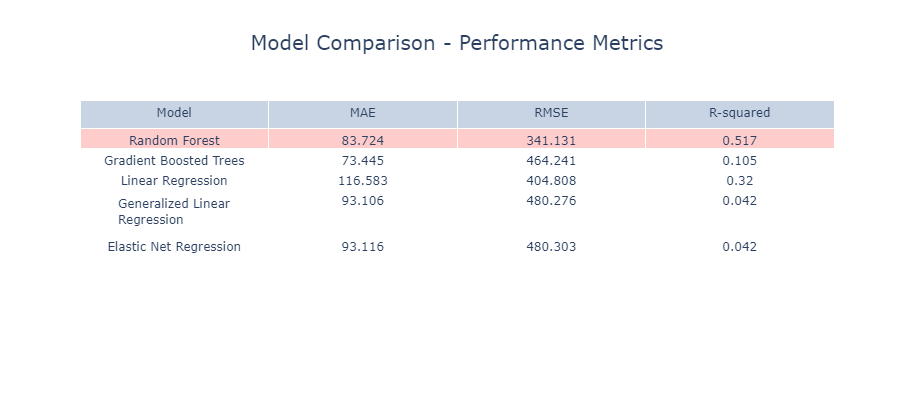

In [38]:
import plotly.graph_objects as go

# Data
models = ['Random Forest', 'Gradient Boosted Trees', 'Linear Regression', 'Generalized Linear Regression', 'Elastic Net Regression']
mae_values = [mae_rf, mae_gbt, mae_lr, mae_glr, mae_en]
rmse_values = [rmse_rf, rmse_gbt, rmse_lr, rmse_glr, rmse_en]
r_squared_values = [r2_rf, r2_gbt, r2_lr, r2_glr, r2_en]

# Define colors for highlighting
highlight_color = 'rgba(255, 0, 0, 0.2)'
default_color = 'rgba(255, 255, 255, 0)'

# Create a table using Plotly
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Model', 'MAE', 'RMSE', 'R-squared']),
    cells=dict(values=[models, mae_values, rmse_values, r_squared_values],
               fill=dict(color=[[highlight_color if val == 'Random Forest' else default_color for val in models],
                                [highlight_color if val == r2_rf else default_color for val in r_squared_values],])))])

# Update layout for better visualization
table_fig.update_layout(
    height=400,
    width=600,
    title=dict(text='Model Comparison - Performance Metrics', font=dict(size=20)),
    title_x=0.5  # Center the title
)

# Display the table figure
table_fig.show()

# Save the table figure to HTML
table_fig.write_html("../../data/plots/score_pred_model_compare.html")


Based on the provided metrics:
- The Random Forest model has the highest R-squared value (0.517), indicating that a higher proportion of the variance in the target variable is explained by the Random Forest model.

- The GBT model has the lowest MAE (73.445) and the Random Forest model has a slightly higher MAE (83.724), suggesting that, on average, the predictions from both models are closer to the actual values.

The Random Forest model demonstrates a greater proportion of variance in the target variable. Examining the feature importance of the model enables us to delve into its distribution, offering insights into what factors are crucial for achieving a high score when posting. For instance, becoming a top creator may actively engage with other submissions, and strive to attract a higher number of comments. Also for a comparable low MAE, the Random Forest model, by considering notable factors such as the number of comments and the word count of the submission, we can enhance our ability to predict the submission score with greater precision, bringing our predictions closer to the actual figures.

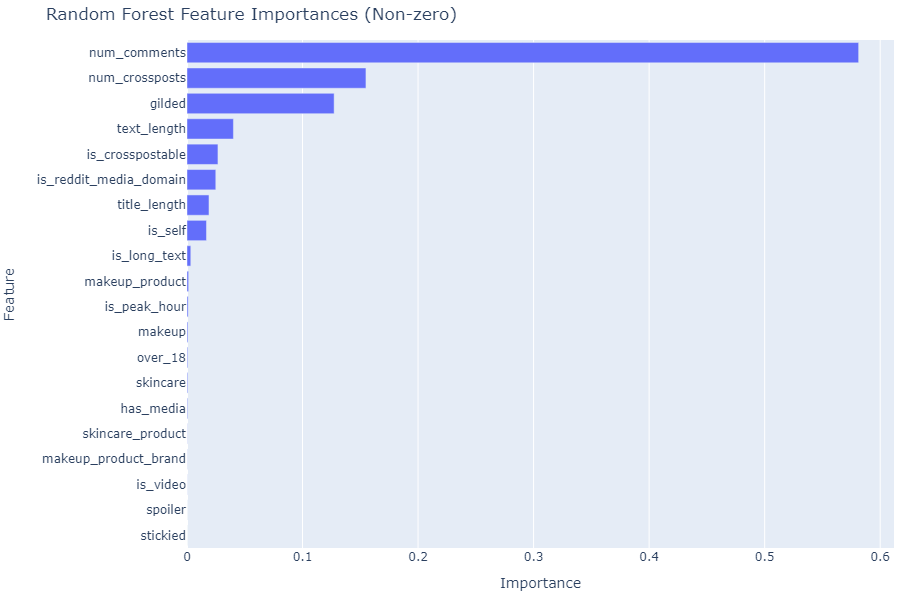

In [19]:
# Get feature importances
feature_importances = model_rf.stages[-1].featureImportances

# Extract feature names
feature_names = assembler.getInputCols()

# Convert SparseVector to dense format
importance_values = feature_importances.toArray()

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': round(importance_values,3)})

# Filter out features with zero importance
importance_df_filtered = importance_df[importance_df['Importance'] > 0]

# Sort the DataFrame by importance in descending order
importance_df_filtered = importance_df_filtered.sort_values(by='Importance', ascending=True)

# Create an interactive bar chart using Plotly
fig = px.bar(importance_df_filtered, x='Importance', y='Feature', orientation='h', title='Random Forest Feature Importances (Non-zero)')
fig.update_layout(height=600, width=800, margin=dict(l=20, r=20, t=40, b=40))
fig.write_html("../../data/plots/score_pred_rf_feature_importance_nonzero.html")

fig.show()


Feature importance analysis reveals key factors influencing the model's score predictions. Notably, the number of comments ("num_comments") emerges as the most influential feature, with a substantial importance score of 0.5814. This underscores the strong correlation between user engagement, measured by the number of comments.

Additionally, the presence of gilded content ("gilded") and the number of crossposts ("num_crossposts") play crucial roles, with importance scores of 0.1273 and 0.1549, respectively. These findings suggest that user recognition through awards and the post's visibility across multiple platforms significantly contribute to a higher predicted score. 

In conclusion, this analysis highlights the importance of user engagement metrics, particularly the number of comments, as the primary driver for predicting post scores on Reddit. Content creators can leverage these insights to tailor their strategies and optimize post scores by fostering community interaction and visibility across platforms.

In [44]:
# Save the model
model_path = "score_pred_model_rf" 
model_rf.write().overwrite().save(model_path)